# Setup

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

# Functions

In [3]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



# Data

In [5]:
xdat = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:

xdat = reduce_mem_usage(xdat)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [7]:
# melt the data into long format
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()

# get proper timestamps
xcal = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [8]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1', 
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'], 
                  axis = 1, inplace = True)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


In [9]:
# for make benefit of speed
xdat = xdat.loc[xdat.date >= '2015-01-01']

# ML approach


In [10]:
xdat.head(4)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
17476868,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1
17476869,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1
17476870,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1
17476871,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,2,2015-01-01,6,1


<AxesSubplot:xlabel='date'>

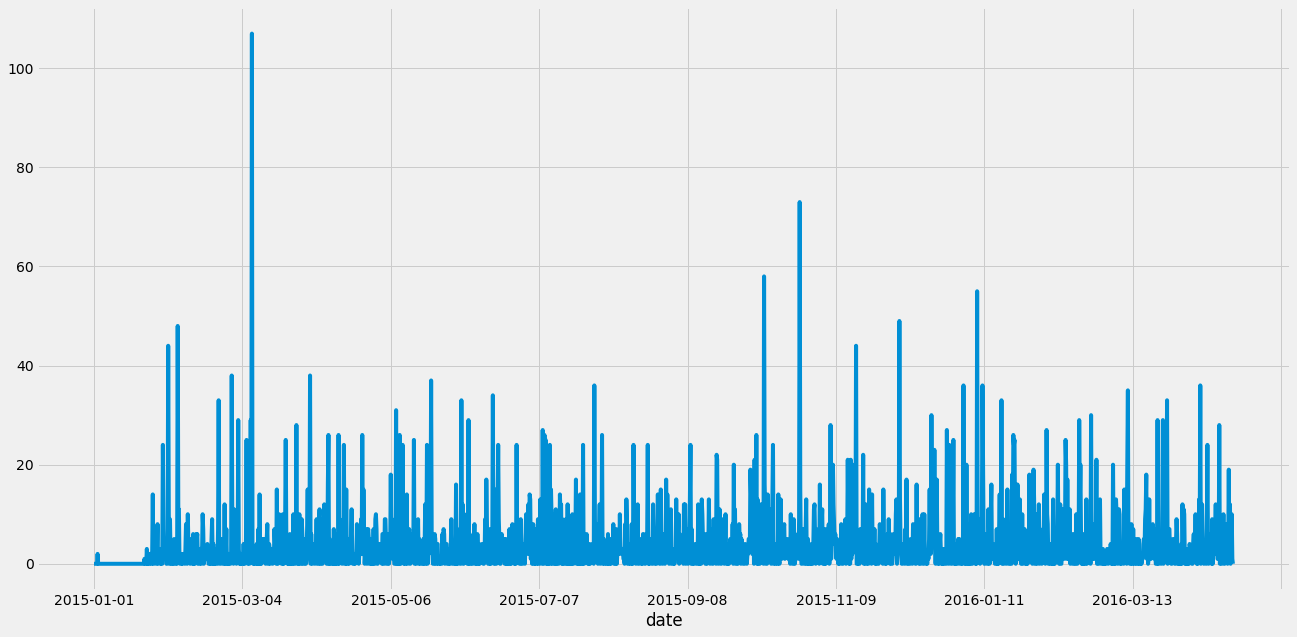

In [11]:
df = xdat.loc[xdat.item_id == 'HOBBIES_1_288' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

<AxesSubplot:xlabel='date'>

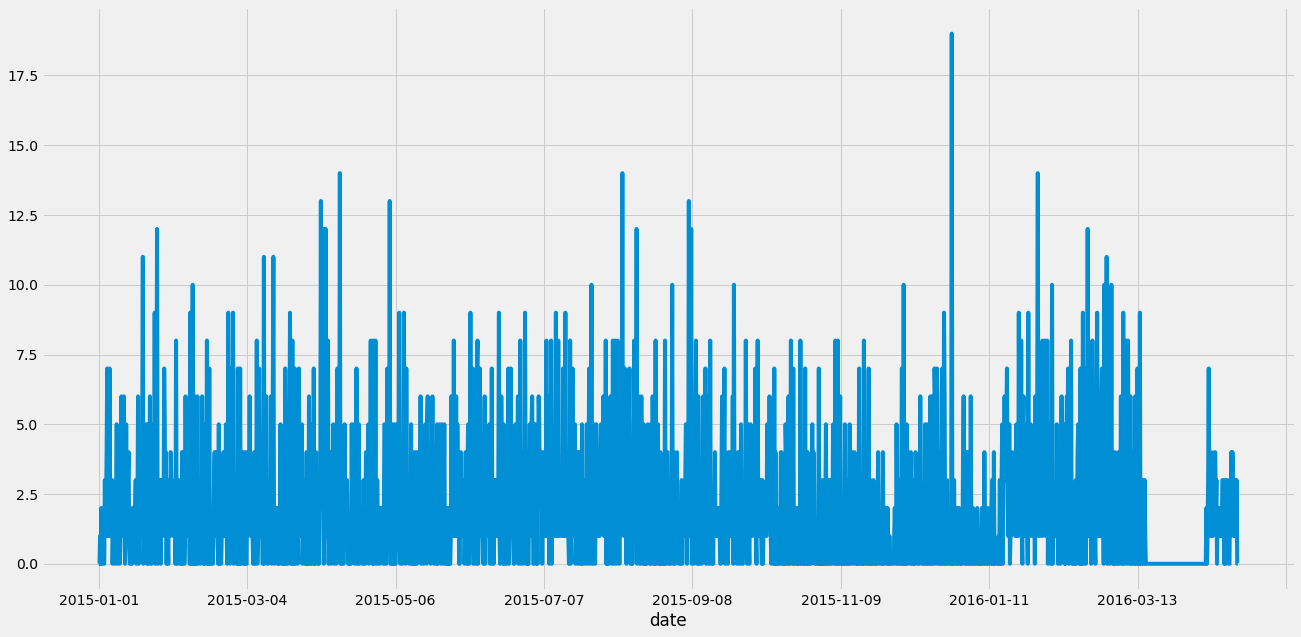

In [12]:
df = xdat.loc[xdat.item_id == 'FOODS_3_823' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

<AxesSubplot:xlabel='date'>

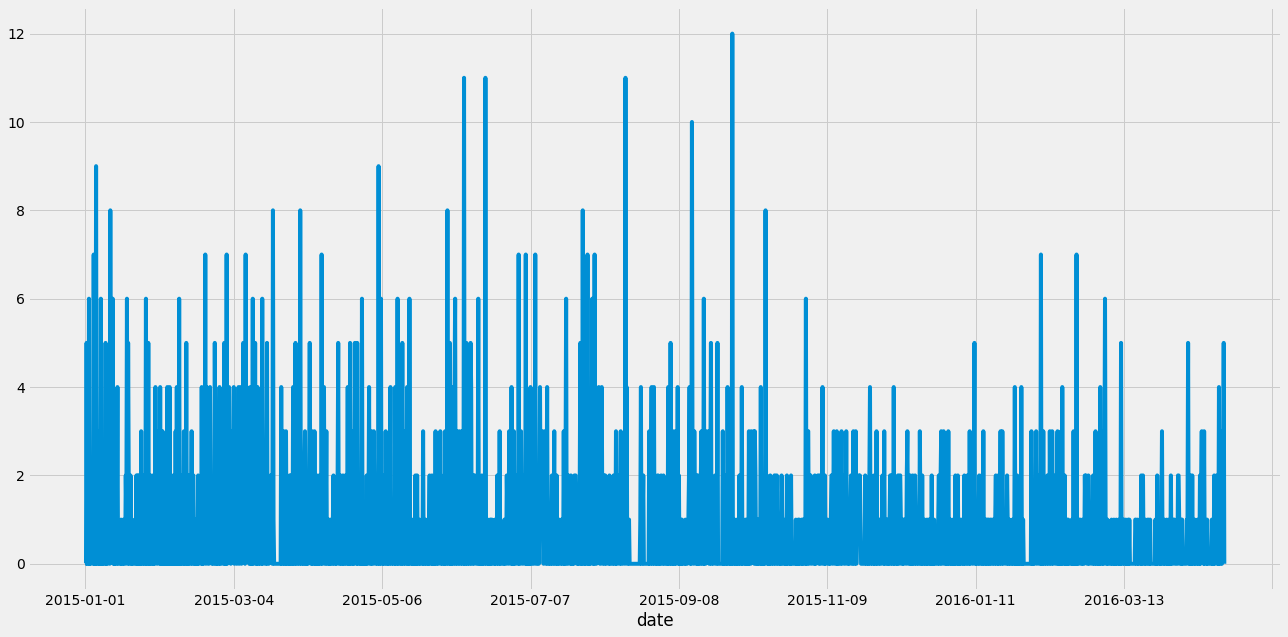

In [13]:
df = xdat.loc[xdat.item_id == 'HOUSEHOLD_2_513' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

In [14]:
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
17476868,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1
17476869,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1
17476870,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1


In [15]:
def create_features(dt, lags = [28], wins = [7]):
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag).fillna(-1)

    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).fillna(-1)
        
    return dt

xdat = create_features(xdat)

xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7
17476868,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1,-1.0,-1.0
17476869,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1,-1.0,-1.0
17476870,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2015-01-01,6,1,-1.0,-1.0


Time-based features:

In [16]:
xdat['date'] = pd.to_datetime(xdat["date"])

date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",

    }
    
for date_feat_name, date_feat_func in date_features.items():
    if date_feat_name in xdat.columns:
        xdat[date_feat_name] = xdat[date_feat_name].astype("int16")
    else:
        xdat[date_feat_name] = getattr(xdat["date"].dt, date_feat_func).astype("int16")

In [17]:
# encode categorical features
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id']
for cc in cat_feats:
    le = LabelEncoder()
    xdat[cc] = le.fit_transform(xdat[cc])
    

In [18]:
# split into train and test
cutoff = xdat.date.max() - pd.to_timedelta(28, unit = 'D')
xtrain = xdat.loc[xdat.date < cutoff].copy()
xvalid = xdat.loc[xdat.date >= cutoff].copy()

del xdat

xtrain.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,week,month,quarter,year,mday
17476868,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,2015-01-01,6,1,-1.0,-1.0,1,1,1,2015,1
17476869,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,2015-01-01,6,1,-1.0,-1.0,1,1,1,2015,1
17476870,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,2015-01-01,6,1,-1.0,-1.0,1,1,1,2015,1


In [19]:
ytrain = xtrain['sales'].copy()
yvalid = xvalid['sales'].copy()

xtrain.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)
xvalid.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)


We are finally ready to go down the usual lgbm path:

In [20]:
dtrain = lgb.Dataset(xtrain , label = ytrain,  free_raw_data=False)
dvalid = lgb.Dataset(xvalid, label = yvalid,   free_raw_data=False)

Can we exploit the nature of the data?

<AxesSubplot:ylabel='Density'>

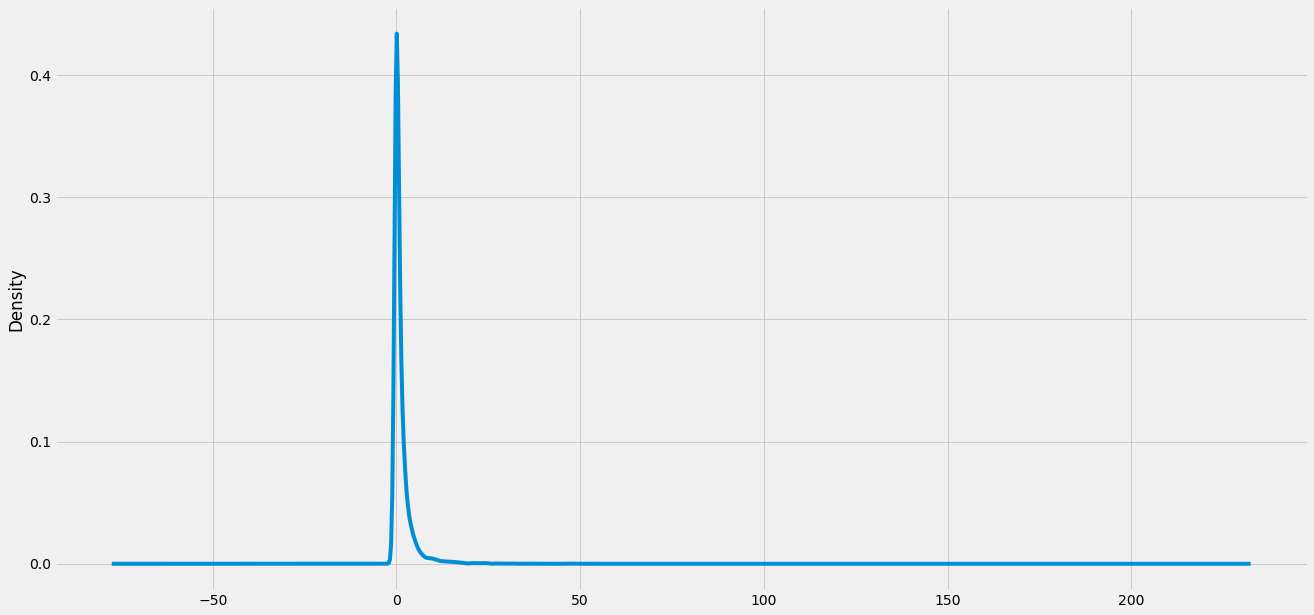

In [21]:
ytrain.sample(10000).plot.density()

Giant spike at zero $\implies$ we need a criterion that allows for a probability mass 

In [22]:

params = {
        "objective" : "poisson",
    
        "metric" : "rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 200,        
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}


m_lgb = lgb.train(params, dtrain, valid_sets = [dtrain, dvalid], 
                  early_stopping_rounds = 150,
                  verbose_eval=25)  

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 5500396, number of used features: 10
[LightGBM] [Info] Start training from score 0.304080
Training until validation scores don't improve for 150 rounds
[25]	training's rmse: 2.79582	valid_1's rmse: 2.63889
[50]	training's rmse: 2.633	valid_1's rmse: 2.45076
[75]	training's rmse: 2.5955	valid_1's rmse: 2.41368
[100]	training's rmse: 2.57701	valid_1's rmse: 2.40017
[125]	training's rmse: 2.56425	valid_1's rmse: 2.39442
[150]	training's rmse: 2.54424	valid_1's rmse: 2.3892
[175]	training's rmse: 2.53024	valid_1's rmse: 2.38882
[200]	training's rmse: 2.51623	valid_1's rmse: 2.39031
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 2.51623	valid_1's rmse: 

More general step: tweedie https://en.wikipedia.org/wiki/Tweedie_distribution

In [23]:
params = {
        "objective" : "tweedie",
    
        "metric" : "rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 1000,        
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}


m_lgb = lgb.train(params, dtrain, valid_sets = [dtrain, dvalid], 
                  early_stopping_rounds = 150,
                  verbose_eval=100) 


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 5500396, number of used features: 10
[LightGBM] [Info] Start training from score 0.304080
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 2.59759	valid_1's rmse: 2.4073
[200]	training's rmse: 2.52722	valid_1's rmse: 2.38217
[300]	training's rmse: 2.49251	valid_1's rmse: 2.39165
Early stopping, best iteration is:
[233]	training's rmse: 2.5128	valid_1's rmse: 2.38162


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

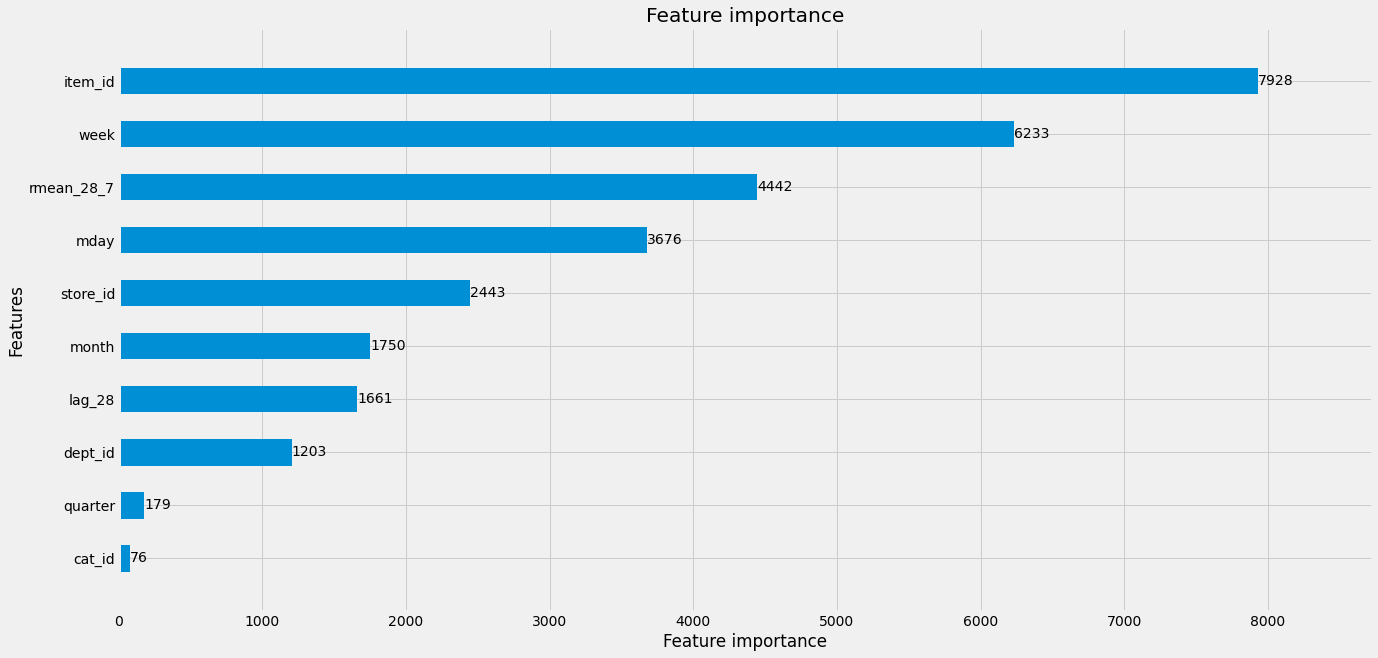

In [24]:
lgb.plot_importance(m_lgb,height = 0.5)

Takeaway:
- time series as regression
- (lagged) rolling statistics
- distribution of target
- careful about ranges $\rightarrow$ extrapolation
